<a href="https://colab.research.google.com/github/RobertNimmo26/fourth-year-project/blob/develop/notebooks/oulad_dataset_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Join Dataset

### GDrive setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [3]:
ls

anonymisedOUDataSet/        StudentAssessmentDaysDeadline.csv
oulad_dataset_combined.csv


## Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
assessments_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/assessments.csv')
courses_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/courses.csv')
student_assessments_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentAssessment.csv')
student_info_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentInfo.csv')
student_registration_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentRegistration.csv')
student_vle_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentVle.csv')
vle_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/vle.csv')

sa_days_deadline_df = pd.read_csv('../OULAD dataset/StudentAssessmentDaysDeadline.csv')

sns.set(rc={'figure.figsize':(11.7,8.27)})

### Join assessment data with individual student assessments

In [6]:
# drop columns not required to join with student_assessments_df
assessments_df.drop(['code_presentation','assessment_type','date','weight'], axis = 1, inplace = True)
assessments_df.code_module.value_counts()

FFF    52
BBB    42
DDD    35
GGG    30
CCC    20
EEE    15
AAA    12
Name: code_module, dtype: int64

In [7]:
# merge each student assessments with assessment data
combined_assessment = pd.merge(student_assessments_df,assessments_df,on='id_assessment')
combined_assessment.drop(['is_banked','date_submitted'],axis = 1,inplace=True)
combined_assessment.head()

,id_assessment,id_student,score,code_module
0,1752,11391,78.0,AAA
1,1752,28400,70.0,AAA
2,1752,31604,72.0,AAA
3,1752,32885,69.0,AAA
4,1752,38053,79.0,AAA


In [8]:
# group assessments by student then course
grouped_student_assessments = combined_assessment.groupby(['id_student','code_module']).mean()
grouped_student_assessments.sort_values('id_student')

grouped_student_assessments.drop(['id_assessment'],axis=1,inplace = True)
grouped_student_assessments.head()

,,score
id_student,code_module,
6516,AAA,61.800000
8462,DDD,87.000000
11391,AAA,82.000000
23629,BBB,82.500000
23698,CCC,74.444444


#### Plot the number of modules each student takes

Text(0, 0.5, 'Number of students')

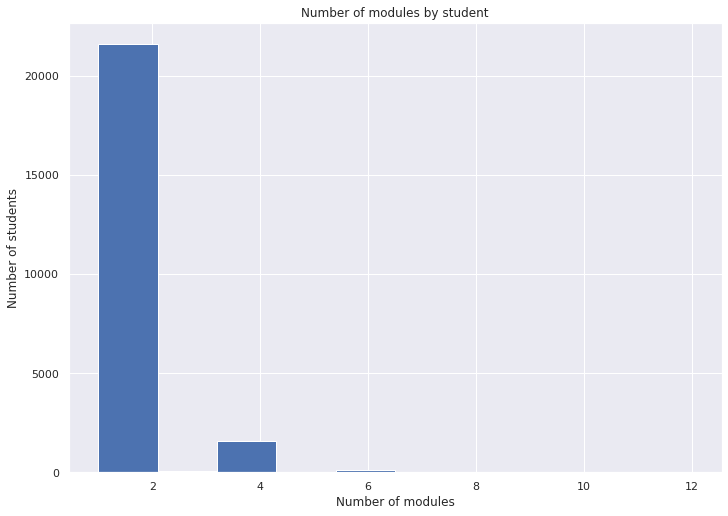

In [9]:
student_all_info = pd.merge(student_info_df,grouped_student_assessments,on='id_student')
fig1 = student_all_info.groupby(['id_student']).code_module.count().sort_values().hist()
fig1.set_title('Number of modules by student')
fig1.set_xlabel('Number of modules')
fig1.set_ylabel('Number of students')

#### Number of sum clicks per student

In [10]:
# click data
def inner_merge(left_df,right_df,right_cols,on_cols):
    right_df = right_df[right_cols]
    left_df = left_df.merge(right_df, on = on_cols)
    return left_df.drop_duplicates()

clicks = inner_merge(student_vle_df,
                      vle_df,
                      ['id_site','code_module','code_presentation','activity_type'],
                      ['id_site','code_module','code_presentation'],
                    )

clicks = clicks.drop(['id_site','date'], axis = 1)

clicks = clicks.groupby(['code_module','code_presentation','id_student','activity_type']).sum().reset_index()

grouped_vle_sum_clicks_activity = pd.pivot_table(data = clicks, 
                            index = ['code_module','code_presentation','id_student'],
                            columns = 'activity_type', 
                            values = [f'sum_click'],
                            fill_value = 0,
                            ).reset_index()

# get rid of multi index
grouped_vle_sum_clicks_activity = pd.concat([grouped_vle_sum_clicks_activity['code_module'],
                              grouped_vle_sum_clicks_activity['code_presentation'],
                              grouped_vle_sum_clicks_activity['id_student'], 
                              grouped_vle_sum_clicks_activity[f'sum_click']], axis=1)

temp = grouped_vle_sum_clicks_activity.groupby(['code_module','code_presentation','id_student']).sum(numeric_only=True, min_count=0)


In [11]:
temp2 = pd.DataFrame()
temp2['sum_click'] = temp.sum(axis=1)

In [12]:
grouped_vle_sum_clicks_activity = pd.merge(grouped_vle_sum_clicks_activity,temp2,on = ['id_student','code_module','code_presentation'],how='left')

In [13]:
temp.sum(axis=1)

code_module  code_presentation  id_student
AAA          2013J              11391          922
                                28400         1409
                                30268          260
                                31604         2007
                                32885         1012
                                              ... 
GGG          2014J              2640965         38
                                2645731        855
                                2648187        291
                                2679821        273
                                2684003        583
Length: 29228, dtype: int64

In [14]:
grouped_vle_sum_clicks_activity.head()

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,0,0,0,0,181,0,138,0,0,553,0,0,0,0,0,0,13,0,32,5,922
1,AAA,2013J,28400,10,0,0,0,393,0,324,0,0,535,0,0,0,0,0,0,12,0,87,48,1409
2,AAA,2013J,30268,0,0,0,0,105,0,59,0,0,66,0,0,0,0,0,0,4,0,22,4,260
3,AAA,2013J,31604,2,0,0,0,502,1,432,0,0,817,0,0,0,0,0,0,19,0,144,90,2007
4,AAA,2013J,32885,0,0,0,0,175,4,204,0,0,491,0,0,0,0,0,0,45,0,79,14,1012


In [15]:
# grouped_vle_sum_clicks_activity = pd.merge(student_vle_df,vle_df[['id_site','activity_type']],on='id_site')
# temp = grouped_vle_sum_clicks_activity

# grouped_vle_sum_clicks_activity = grouped_vle_sum_clicks_activity.groupby(['id_student','code_module','activity_type']).sum().reset_index()

# grouped_vle_sum_clicks_activity.drop(['id_site','date'],axis=1,inplace=True)

# grouped_vle_sum_clicks_activity.head(20)

In [16]:
# # number of clicks a student makes for a module
# grouped_vle_sum_clicks = student_vle_df.groupby(['id_student','code_module']).sum()

# # Remove uneeded columns
# grouped_vle_sum_clicks.drop(['id_site','date'],axis=1,inplace=True)
# grouped_vle_sum_clicks.head()

In [17]:
# merge grouped_vle_sum_clicks_activity to student_all_info to a new dataframe called df
df = pd.merge(student_all_info,grouped_vle_sum_clicks_activity,on = ['id_student','code_module','code_presentation'],how='left')

In [18]:
# remove rows with null
df.dropna(inplace=True)

In [19]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0


In [20]:
# # categorise df columns
# df.code_module = pd.Categorical(df.code_module)
# df.code_presentation = pd.Categorical(df.code_presentation)
# df.gender = pd.Categorical(df.gender)
# df.region = pd.Categorical(df.region)
# df.highest_education = pd.Categorical(df.highest_education)
# df.imd_band = pd.Categorical(df.imd_band)
# df.age_band = pd.Categorical(df.age_band)
# df.disability = pd.Categorical(df.disability)
# df.final_result = pd.Categorical(df.final_result)


In [21]:
df.final_result

0               Pass
1               Pass
2               Pass
3               Pass
4               Pass
            ...     
30353    Distinction
30354    Distinction
30355           Pass
30356      Withdrawn
30357    Distinction
Name: final_result, Length: 28687, dtype: object

In [22]:
# replace final result string with numerical representation
df.final_result = df.final_result.replace({'Withdrawn':0,'Fail':1,'Pass':2,'Distinction':3})

### Module AAA - statistics

In [23]:
# select every 
module_AAA = df.loc[df['code_module'] == "AAA"]
print(module_AAA.shape)
#module_AAA = module_AAA.loc[module_AAA['sum_click'] > 50]

# remove withdrawn
module_AAA = module_AAA[module_AAA.final_result != 0]

# 2 results - pass or fail
module_AAA['final_result'] = module_AAA['final_result'].replace({1:0, 2:1, 3:1})
module_AAA.shape

(688, 34)


(594, 34)

In [24]:
module_AAA.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0


In [25]:
#students who completed the module >1 are included
module_AAA.groupby('id_student',as_index=False).size().sort_values(by='size')

,id_student,size
0,6516,1
388,998493,1
389,1035023,1
390,1045203,1
391,1105478,1
...,...,...
589,2698257,1
192,295741,2
80,147756,2
547,2596621,2


In [26]:
# split students by pass or fail
module_AAA_fail = module_AAA.loc[module_AAA['final_result'] == 0]
module_AAA_pass = module_AAA.loc[module_AAA['final_result'] == 1]

#### Plot distribution of sum clicks by pass and fail

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of sum clicks by pass and fail')

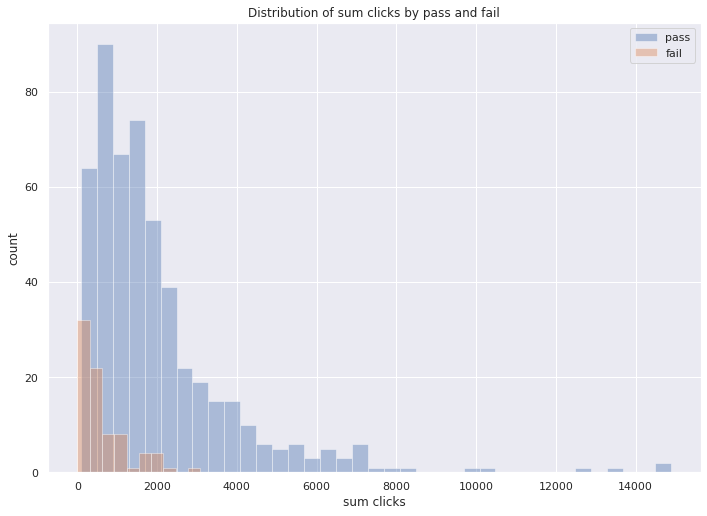

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(module_AAA_pass.groupby(['id_student'])['sum_click'].sum(), kde=False)
sns.distplot(module_AAA_fail.groupby(['id_student'])['sum_click'].sum(), kde=False)

plt.legend(labels=['pass',"fail"])

plt.xlabel("sum clicks")
plt.ylabel("count")

plt.title("Distribution of sum clicks by pass and fail")

#### Plot distribution of assessment scores by pass and fail

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of assessment scores by pass and fail')

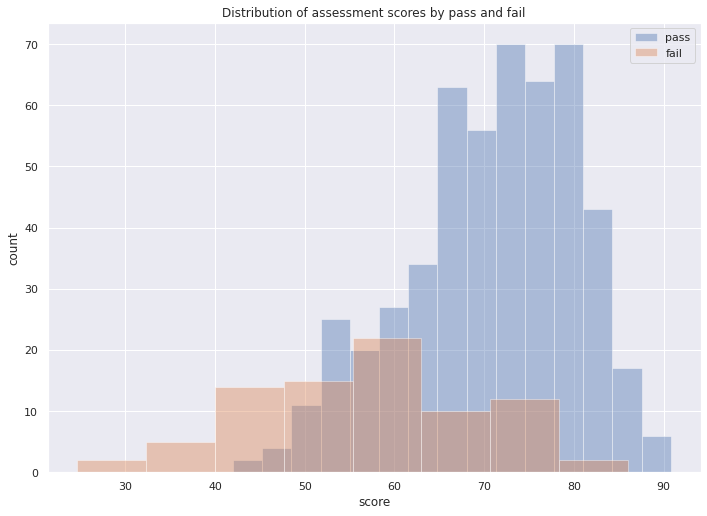

In [28]:
sns.distplot(module_AAA_pass["score"],kde=False)
sns.distplot(module_AAA_fail["score"],kde=False)

plt.legend(labels=['pass',"fail"])

plt.xlabel("score")
plt.ylabel("count")

plt.title("Distribution of assessment scores by pass and fail")

#### Plot final result by gender

In [29]:
gender_temp = []
final_result_temp = []

for i in list(module_AAA.groupby('id_student')['gender']):
  gender_temp.append(i[1].unique()[0])
  
for i in list(module_AAA.groupby('id_student')['final_result']):
  final_result_temp.append(i[1].unique()[0])

gender_temp = pd.DataFrame(gender_temp, columns=['gender'])
final_result_temp = pd.DataFrame(final_result_temp, columns=['final_result'])

In [30]:
joined_gender_results = gender_temp.join(final_result_temp)

Text(0, 0.5, 'Count')

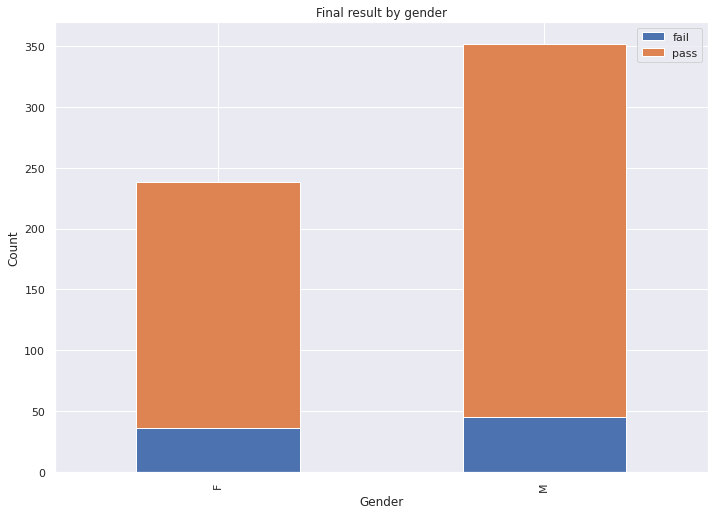

In [31]:
pd.crosstab(joined_gender_results['gender'],joined_gender_results['final_result']).plot.bar(stacked=True)
plt.title("Final result by gender")

plt.legend(labels=['fail','pass'])

plt.xlabel("Gender")
plt.ylabel("Count")

### Predictions

In [32]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0


In [33]:
df.to_csv('oulad_dataset_combined.csv')

#### Evaluation

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score


def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision_macro = precision_score(true_labels, predictions, average='macro')
  precision_weighted = precision_score(true_labels, predictions, average='weighted')

  recall = recall_score(true_labels, predictions, average='macro')
  accuracy = accuracy_score(true_labels, predictions)
  f1 = fbeta_score(true_labels, predictions, beta=1, average='macro')#, labels=np.unique(predictions)) #1 means f_1 measure

  print("Classifier '%s' has Acc=%0.3f P_macro=%0.3f P_weighted=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision_macro,precision_weighted,recall,f1))
  # Specify three digits instead of the default two.
  print(classification_report(true_labels, predictions, digits=3))
  print('\nConfusion matrix:\n') # Note the order here is true, predicted, odd.
  cm = confusion_matrix(true_labels, predictions)
  labels = np.unique(true_labels)
  print(pd.DataFrame(cm, index=labels, columns=labels))

  plt.subplots(figsize=(8,7))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['fail', 'pass']); ax.yaxis.set_ticklabels(['fail', 'pass'])

#### Split dataset

In [35]:
from sklearn.model_selection import train_test_split

def split_dataset(X, Y):   
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    return X_train, Y_train, X_test, Y_test


#### Prepare data

In [36]:
from sklearn import preprocessing

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


class MultiColumnOHEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [37]:
# categorise df columns
df.code_module = pd.Categorical(df.code_module)
df.code_presentation = pd.Categorical(df.code_presentation)
df.gender = pd.Categorical(df.gender)
df.region = pd.Categorical(df.region)
df.disability = pd.Categorical(df.disability)
df.final_result = pd.Categorical(df.final_result)

from sklearn.pipeline import Pipeline

encoding_pipeline = Pipeline([
    ('encoding_label',MultiColumnLabelEncoder(columns=['highest_education','imd_band','age_band'])),
])
df = encoding_pipeline.fit_transform(df)

In [38]:
# remove withdrawl
df = df[df.final_result != 0]
Y = df['final_result'].replace({1:0, 2:1, 3:1}) # Fail; Pass, Distinction -> Incomplete; Complete
X = df.drop('final_result', axis=1)

# Convert categorical variable into indicator variables. One-hot encoding
X = pd.get_dummies(X)

In [39]:
X.head()

,id_student,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,score,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y
0,11391,1,9,2,0,240,82.0,0.0,0.0,0.0,0.0,181.0,0.0,138.0,0.0,0.0,553.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,922.0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,28400,1,2,1,0,60,66.4,10.0,0.0,0.0,0.0,393.0,0.0,324.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1409.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,31604,0,5,1,0,60,76.0,2.0,0.0,0.0,0.0,502.0,1.0,432.0,0.0,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2007.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,32885,2,5,0,0,60,54.4,0.0,0.0,0.0,0.0,175.0,4.0,204.0,0.0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1012.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,38053,0,8,1,0,60,68.0,7.0,0.0,0.0,0.0,829.0,4.0,512.0,0.0,0.0,885.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,91.0,45.0,2384.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [40]:
X_train, Y_train, X_test, Y_test = split_dataset(X,Y)

#### Dummy Classifier

Evaluation for: Dummy Classifier test dataset
Classifier 'Dummy Classifier test dataset' has Acc=0.736 P_macro=0.368 P_weighted=0.542 R=0.500 F1=0.424
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1512
           1      0.736     1.000     0.848      4226

    accuracy                          0.736      5738
   macro avg      0.368     0.500     0.424      5738
weighted avg      0.542     0.736     0.625      5738


Confusion matrix:

   0     1
0  0  1512
1  0  4226


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

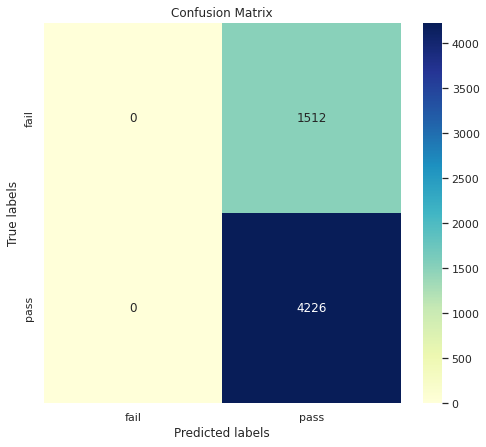

In [41]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, Y_train)

test_dt_predictions = dummy_classifier.predict(X_test)

evaluation_summary("Dummy Classifier test dataset",  test_dt_predictions, Y_test)

#### Decision Tree Classifier

Evaluation for: Decision Tree Classifier test dataset
Classifier 'Decision Tree Classifier test dataset' has Acc=0.812 P_macro=0.758 P_weighted=0.814 R=0.762 F1=0.760
              precision    recall  f1-score   support

           0      0.640     0.656     0.648      1512
           1      0.876     0.868     0.872      4226

    accuracy                          0.812      5738
   macro avg      0.758     0.762     0.760      5738
weighted avg      0.814     0.812     0.813      5738


Confusion matrix:

     0     1
0  992   520
1  557  3669


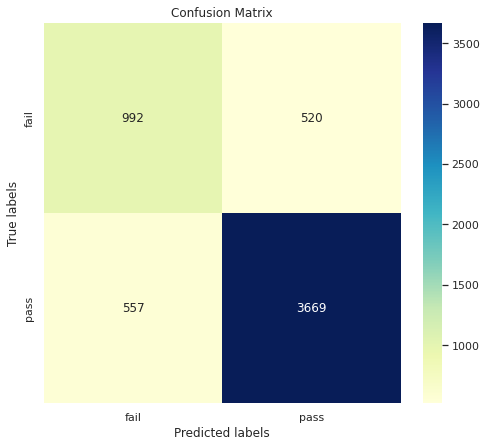

In [42]:
from sklearn.tree import DecisionTreeClassifier 

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, Y_train)

test_dt_predictions = dt_classifier.predict( X_test)

evaluation_summary("Decision Tree Classifier test dataset",  test_dt_predictions, Y_test)

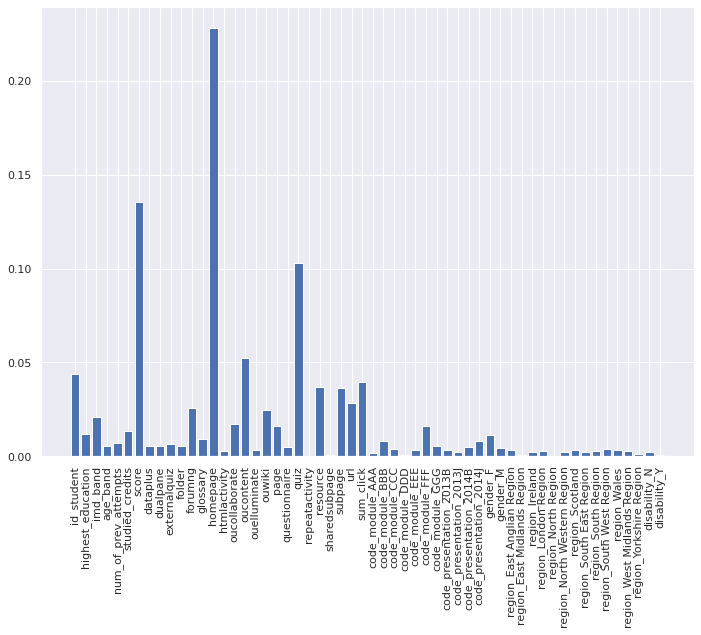

In [43]:
feature_names = dt_classifier.feature_names_in_

# get importance
importance = dt_classifier.feature_importances_

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

### Guassian NB

Evaluation for: Gaussian NB Classifier test dataset
Classifier 'Gaussian NB Classifier test dataset' has Acc=0.539 P_macro=0.645 P_weighted=0.782 R=0.662 F1=0.538
              precision    recall  f1-score   support

           0      0.356     0.921     0.513      1512
           1      0.935     0.403     0.563      4226

    accuracy                          0.539      5738
   macro avg      0.645     0.662     0.538      5738
weighted avg      0.782     0.539     0.550      5738


Confusion matrix:

      0     1
0  1393   119
1  2524  1702


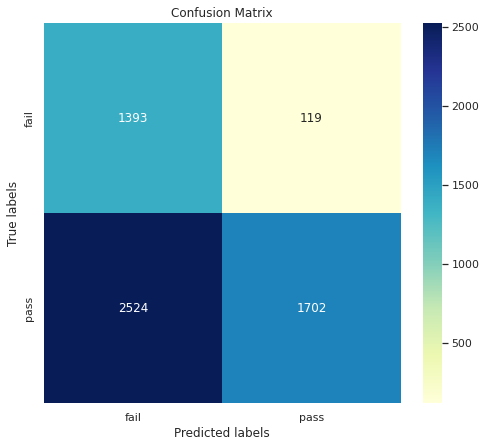

In [44]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, Y_train)

test_gnb_predictions = gnb.predict( X_test)

evaluation_summary("Gaussian NB Classifier test dataset",  test_gnb_predictions, Y_test)

[ 1.35935866e-03  0.00000000e+00  2.43987452e-04  0.00000000e+00
  0.00000000e+00 -5.57685605e-04  3.76437783e-03  3.48553503e-05
  6.97107006e-05 -1.04566051e-04  0.00000000e+00 -7.31962356e-04
  2.02161032e-03 -1.03868944e-02  1.74276751e-04  9.41094458e-04
 -1.18508191e-03 -3.13698153e-04  1.53712095e-02  1.04566051e-04
  3.48553503e-05  1.77762287e-03  0.00000000e+00  2.26559777e-03
  0.00000000e+00 -2.61415127e-03  8.01673057e-04 -1.23736494e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


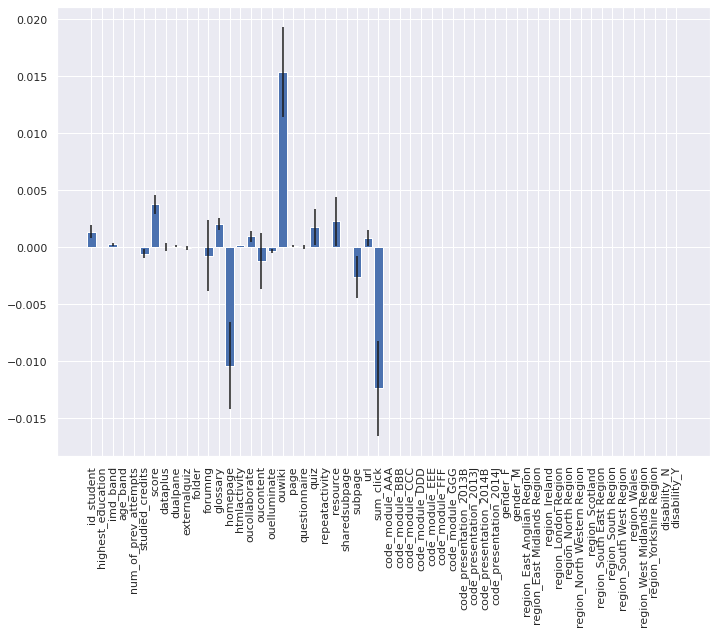

In [45]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(gnb, X_test, Y_test)
print(importance.importances_mean)

feature_names = gnb.feature_names_in_

plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

#### Random Forest

Evaluation for: Gaussian NB Classifier test dataset
Classifier 'Gaussian NB Classifier test dataset' has Acc=0.878 P_macro=0.868 P_weighted=0.876 R=0.805 F1=0.829
              precision    recall  f1-score   support

           0      0.851     0.651     0.738      1512
           1      0.885     0.959     0.921      4226

    accuracy                          0.878      5738
   macro avg      0.868     0.805     0.829      5738
weighted avg      0.876     0.878     0.873      5738


Confusion matrix:

     0     1
0  985   527
1  172  4054


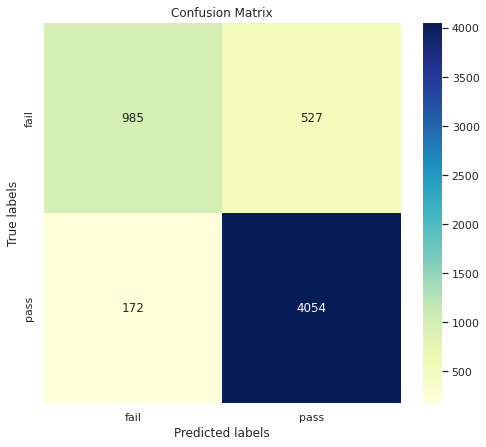

In [46]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(n_estimators = 200,
                             max_features = 'sqrt', 
                             min_samples_split = 10, 
                            )

randomforest.fit(X_train, Y_train)

test_randomforest_predictions = randomforest.predict( X_test)

evaluation_summary("Gaussian NB Classifier test dataset",  test_randomforest_predictions, Y_test)

[ 1.08051586e-03  1.84733357e-03  7.31962356e-04  8.36528407e-04
  6.97107006e-04  5.22830254e-04  2.44684559e-02  4.87974904e-04
  6.97107006e-05  2.43987452e-04  5.57685605e-04  2.50958522e-03
  5.22830254e-04  6.93621471e-03  4.53119554e-04  1.60334611e-03
  6.27396305e-03  3.83408853e-04  6.72708261e-03  4.07807598e-03
  5.22830254e-04  2.76402928e-02  0.00000000e+00  5.29801325e-03
  0.00000000e+00  2.30045312e-03  2.61415127e-03  1.25130708e-02
  4.53119554e-04  2.99756013e-03  1.53363541e-03 -9.06239108e-04
  1.35935866e-03  2.54444057e-02  1.53363541e-03  4.53119554e-04
  7.31962356e-04  6.62251656e-04  1.88218892e-03  1.39421401e-03
  9.41094458e-04 -2.78842802e-04 -1.04566051e-04 -3.48553503e-04
 -2.09132102e-04  3.48553503e-05 -1.39421401e-04  2.09132102e-04
  1.04566051e-04  2.22044605e-17  5.22830254e-04 -3.48553503e-05
  1.39421401e-04 -1.04566051e-04  1.74276751e-04 -4.53119554e-04]


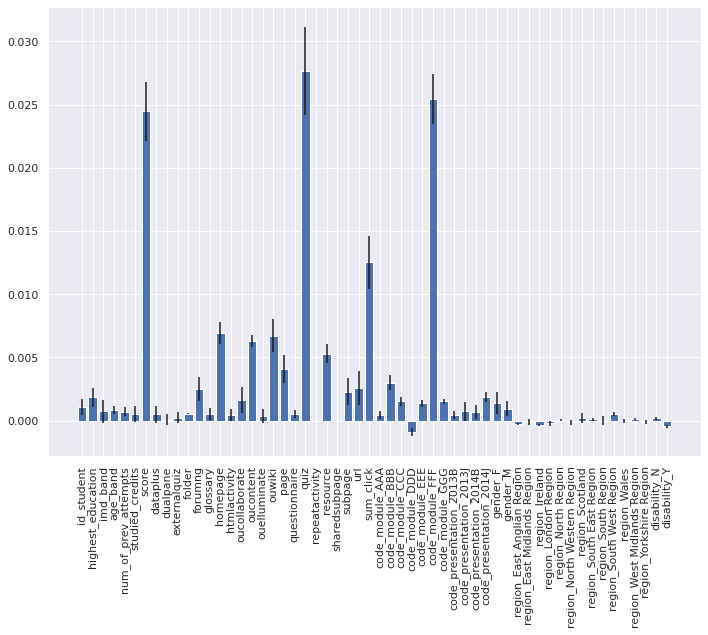

,importance,column
21,0.027640,quiz
33,0.025444,code_module_FFF
6,0.024468,score
27,0.012513,sum_click
13,0.006936,homepage
18,0.006727,ouwiki
16,0.006274,oucontent
23,0.005298,resource
19,0.004078,page
29,0.002998,code_module_BBB


In [47]:
importance = permutation_importance(randomforest, X_test, Y_test)
print(importance.importances_mean)

feature_names = randomforest.feature_names_in_

plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

importance_table = pd.DataFrame({'importance': importance['importances_mean'],
                                 'column': feature_names })
importance_table.sort_values(by = 'importance', ascending = False)[:20]

[3.06134657e-02 1.14492106e-02 1.74309700e-02 4.39783216e-03
 7.12167333e-03 1.27791096e-02 1.28658955e-01 7.72292078e-03
 5.47225679e-03 9.25139796e-03 5.53668078e-03 4.70674041e-02
 9.63635576e-03 1.02919324e-01 3.49857489e-03 1.86866334e-02
 6.02898750e-02 5.32062888e-03 2.95423099e-02 1.81704649e-02
 7.15783547e-03 8.20803805e-02 1.04629566e-04 5.37073806e-02
 5.18890243e-04 4.19986155e-02 3.53603206e-02 1.15258943e-01
 3.13206839e-03 9.55899673e-03 5.20632162e-03 3.52227682e-03
 4.64625136e-03 2.18312018e-02 6.25874356e-03 4.29170853e-03
 3.70105872e-03 3.70220708e-03 5.70624691e-03 7.48538841e-03
 7.32546773e-03 3.36534510e-03 2.68369447e-03 2.43388798e-03
 3.25671115e-03 1.70928419e-03 3.51331043e-03 3.71332790e-03
 2.43657118e-03 2.84637480e-03 2.60014261e-03 2.60536294e-03
 3.15568764e-03 2.50515524e-03 2.54266289e-03 2.51150470e-03]


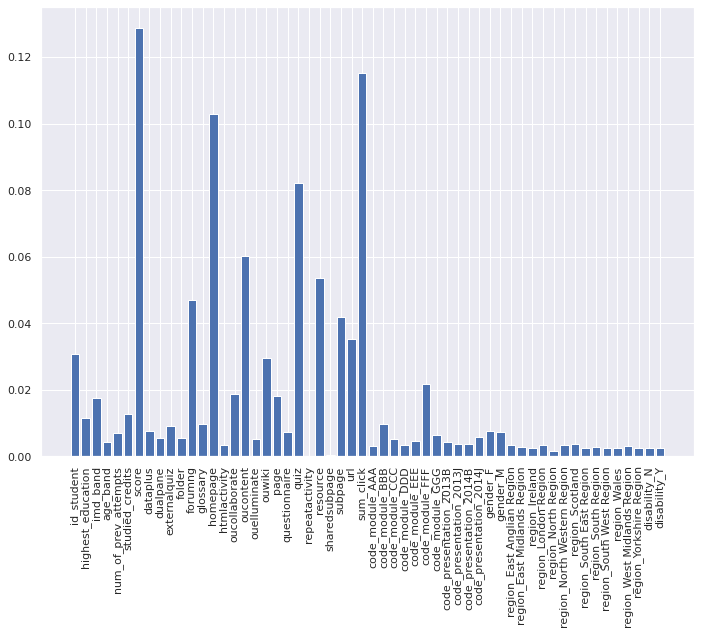

,importance,column
6,0.128659,score
27,0.115259,sum_click
13,0.102919,homepage
21,0.082080,quiz
16,0.060290,oucontent
23,0.053707,resource
11,0.047067,forumng
25,0.041999,subpage
26,0.035360,url
0,0.030613,id_student


In [48]:
importance = randomforest.feature_importances_
print(importance)

feature_names = randomforest.feature_names_in_

plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

importance_table = pd.DataFrame({'importance': importance,
                                 'column': feature_names })
importance_table.sort_values(by = 'importance', ascending = False)[:20]